In [1]:
import jax
import jax.numpy as np
import os

os.environ["CHALK_JAX"] = "1"
from chalk import *
from colour import Color
from IPython.display import HTML
import jax
import optax
import chalk.transform
import numpy as onp
import glob
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
import random


eps = 1e-3

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# A Tour of Differentiable Rasterization

By [Sasha Rush](https://x.com/srush_nlp)

Inspired by

* [Differentiable Vector Graphics Rasterization for Editing and Learning](https://cseweb.ucsd.edu/~tzli/diffvg/)
* [Efficient GPU Path Rendering Using Scanline Rasterization](http://kunzhou.net/zjugaps/pathrendering/GPUpathrendering.pdf)
* [Monoids: Theme and Variations](https://core.ac.uk/download/pdf/76383233.pdf)
* [Jax](https://jax.readthedocs.io/en/latest/pytrees.html)


Given a program that produces a vector representation of an image (think SVG), *rasterization* turns it into
a pixel representation (think PNG). If we have a image we can see how close we got.

$$\begin{align*}
  \text{vector} &= \text{program}(x) \\
  \text{image} &= \text{rasterizer}(x) \\
  {\cal L}(\text{png}, \text{target}) &= \| \text{image} - \text{target} \| \\
\end{align*}$$

Unfortunately this process is not inherently differentiable. Moreover, it doesn't easily run in modern
deep learning frameworks like Jax or PyTorch. The goal of this post is to walk through this calculation.

$$\text{Goal:}   \frac{d {\cal L}}{dx} = \frac{d {\cal L}}{d\ \text{image}} \frac{d\ {\text{image}}}{d\ \text{vector}} \frac{d\ \text{vector}}{dx}$$


To make this all more tangible, say we have a target image and a program
that can draw ellipses based on their locations, size, and rotation. Differentiable rasterization would let us
use gradient descent to adjust the parameters $x$ to match the image.



In [2]:
HTML(
    """

<script src="https://unpkg.com/freezeframe/dist/freezeframe.min.js"></script>

<div><img src="smiley3.webp" width="40%"><div style="width:40%; float:right"><img class="freezeframe" id="smiley" src="smiley1.gif" width="40%"></div></div>
<script>
new Freezeframe({selector: '#smiley', overlay:true});
</script>

"""
)

While this method has applications in computer graphics, the goal of this blog is less about
graphics, in which I am a novice, and more about understanding differentiable programming.
If autodiff + GPUs is the future, then it is important to be able to write hard programs
in a differentiable style (beyond just the n'th Transformer).

The blog is in 5 parts. It is assumes knowledge of Jax/NumPy, but no background in graphics. We'll build everything up visually.

* [Section 1: Transforms, Arcs, Paths](#section-1-transforms-arcs-paths)
* [Section 2: Jax x Graphics](#section-2-jax-x-graphics)
* [Section 3: Tracing](section-3-tracing)
* [Section 4: Vector -> Image](section-4-vector---image)
* [Section 5: Differentiable Rasterization](section-5-differentiable-rasterization)

In [3]:
import imageio.v3 as imageio
import base64

# import PIL
ff_id = 0


def animate_out(images, steps=36, rate=20, **kwargs):
    global ff_id
    # with imageio.get_writer("/tmp/out.gif", loop=0, fps=rate, **kwargs) as writer:
    writer = []
    for im in images:
        image = imageio.imread(im)
        # image = PIL.Image.open(im)
        writer.append(image)
    # writer[0].save('/tmp/out.gif', save_all=True, append_images=writer,
    #               loop=0, duration=200, transparency=0, disposal=0)
    ff_id += 1

    imageio.imwrite(f"out.{ff_id}.gif", writer, loop=0, fps=rate, **kwargs)

    # imageio.mimsave(
    # base = base64.b64encode(open("/tmp/out.gif", 'br').read()).decode('ascii')
    return HTML(
        f"""
  <div style="text-align:center;"><div style="width:70%; margin:auto;"><img src="out.{ff_id}.gif" id='ff{ff_id}'></div></div>
<script>
new Freezeframe({{
  selector: '#ff{ff_id}'  
}});
</script>



  """
    )


grid = rectangle(4, 4).fill_color("white").line_width(0) + (
    make_path([(-2, 0), (2, 0)]) + make_path([(0, -2), (0, 2)])
).line_color("grey").line_width(1)
hgrid = rectangle(10, 10).fill_color("white").line_width(0).align_tl()
bgrid = rectangle(100, 100).fill_color("white").line_width(0).align_tl()


def animate(fn1, steps=36, rate=20, grid=grid, lw=True, **kwargs):
    os.system("rm /tmp/render*.png /tmp/out.gif 2> /dev/null")
    images = []

    def fn(t):
        im = fn1(t / steps)
        if isinstance(im, tuple):
            im, extra = im
        else:
            extra = empty()

        return hcat(
            [grid + (im.with_envelope(empty()).line_width(2 if lw else None)), extra],
            0.4,
        ).layout(500)

    if chalk.transform.JAX_MODE:
        fn = jax.jit(fn)

    for t in range(1, steps):
        out, h, w = fn(t)
        p = f"/tmp/render.{t:03d}.png"
        chalk.backend.cairo.prims_to_file(out, p, h, w)
        images.append(p)
    return animate_out(images)


@jax.vmap
def inner(j, i, a):
    op = np.minimum(1.0, np.abs(a))
    return (
        rectangle(0.75, 0.75, 0.1)
        .center_xy()
        .translate(i, j)
        .fill_color(
            op * np.where(a > 0, to_color("blue"), to_color("red")) + (1 - op) * 1
        )
        .line_width(0)
    )


@jax.jit
def show_affine(aff):
    out = inner(np.arange(9) // 3, np.arange(9) % 3, aff.reshape(-1))
    return out.center_xy().scale(
        0.5
    )  # (vrule(3).line_width(1) |  | vrule(3).line_width(1)).flatten()


@jax.jit
def show_color(color):
    out = inner(np.arange(3), np.zeros(3), color.reshape(-1))
    return out.center_xy().scale(
        0.5
    )  # (vrule(3).line_width(1) |  | vrule(3).line_width(1)).flatten()


import copy


def show_arc(a):
    a = copy.deepcopy(a)
    angles = a.segments.angles
    angles = angles.at[0, 1].set(360)
    a.segments.angles = angles
    return a

## Section 1: Transforms, Arcs, Paths

The first stage is to get to a vector graphics specification.
That is,

$$\begin{align*}
  \text{vector} &= \text{program}(x) \\
\end{align*}
$$

To arrive here, we need to convince ourselves that this process is
fully differentiable and expressible in Jax. This will also
allow us to introduce the basic primitives of vector graphics.

### Transforms

A *transform* is an affine function of a 2D point.
Given a point $(x, y)$, we produce a point $(x', y')$
where $x' = a x + b y + c$ and $y' = d x + e y + f$.
This will allow us to mathematically represent intuitive
notions of scaling, rotation, and translation.

We can represent these affine functions as a 3x3 matrices.
$$\begin{align*}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} a & b & c \\ d & e & f \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \\
\end{align*}$$
The key trick being to represent 2D points in 3D with a fixed 1 in the last position. We can the apply transforms to points, lines, shapes, or other transforms etc.
As these are standard matrix operations, they naturally have meaningful derivatives, which autodiff can provide for us.


We start by applying them to a simple line.

In [4]:
line = arc_seg(V2(1, 1), 1e-3).stroke()

Translations have an identity scaling and use the last column for the offet. We show the transform on the right side.

In [5]:
def translate(t: float):
    "t is a float between 0 and 1"
    affine = tx.translation(V2(0, t))
    return line.apply_transform(affine), show_affine(affine)


animate(translate)

Scaling uses the diagonal.


In [7]:
def scale(t):
    affine = tx.scale(t)
    return line.apply_transform(affine), show_affine(affine)


animate(scale)

Rotation uses the off-diagonal.

In [9]:
def rotate(t):
    affine = tx.rotation(t * 2 * np.pi)
    return line.apply_transform(affine), show_affine(affine)


animate(rotate)

We overload the + operator to represent composition.
Here two lines are combined in a single image. The first
is rotated and the second is rotated in the opposite direction
using the inverse of the transform.

In [10]:
def cat(t):
    affine = tx.rotation(t * 2 * np.pi)
    affine2 = tx.inv(affine)
    return line.apply_transform(affine) + line.apply_transform(affine2), show_affine(
        affine
    ) | show_affine(affine2)


animate(cat)

Colors are also represented as vectors and can be combined.

$$ \text{color} = \begin{bmatrix} r \\ g \\ b \end{bmatrix}$$

In [12]:
def color_line(t):
    red = to_color("red")
    blue = to_color("blue")
    color = t * red + (1 - t) * blue
    return line.line_color(color), show_color(color)


animate(color_line)

### Arcs and Shapes


The only drawing primitive we will provide is an *arc*.
Arcs are created by providing a vector offset and the bend height.
Here's what that does.


In [14]:
def arc(t):
    v = V2(1, 0)
    a_s = arc_seg(v, t)
    return a_s.stroke()


animate(arc)

These values are converted internally to an implicit circle using
some (differentiable) high-school trigonometry.
We store the radius of this circle, the start angle, and the offset.
Here is what these arcs look like by composing the arc and the
internal circle representation.

In [16]:
def arc(t):
    v = V2(1, 0)
    a_s = arc_seg(v, t)
    return a_s.stroke().line_width(2) + show_arc(a_s).stroke().line_width(0.1)


animate(arc, lw=False)

We can chain arcs together, again using the overloaded `+` operator to make a *path*.
Paths can be closed to indicate a filled shape.
Filled paths made with chained arcs will be the core element we work with.

(Note chaining must be done before calling `stroke()` since `+` is
also used for composition.)

In [18]:
def closed(t):
    v = V2(1, 0)
    return (arc_seg(v, t) + arc_seg(-v, -0.2)).close().stroke()


animate(closed)

Finally we can put everything together to create a circle function.

In [20]:
def circle_at(p, r):
    "Draw a circle at `p` with radius `r`"
    # Draw a circle with radius 1 centered at (0, 1)
    circle = (arc_seg(V2(0, 2), 1) + arc_seg(V2(0, -2), 1)).close().stroke()
    # Move the circle to p and scale to radius r
    affine = tx.translation(p) @ tx.scale(r) @ tx.translation(V2(0, -1))
    return circle.apply_transform(affine)


def draw_circle(t):
    return circle_at(t, t)


animate(draw_circle)

## Section 2: Jax x Graphics

Since the math underlying these primitives is in NumPy, we can use Jax to
work with them. The key requirement is that the paths be made up
of NumPy arrays and are composed with Jax [PyTrees](https://jax.readthedocs.io/en/latest/pytrees.html).

The downside of Jax is that we will not be able to use a lot of standard python functions, and
will have to write everything in a strick functional style without `if's`. This will make
later things harder.

But there are several really nice benefits that Jax provides. The first is that we can
use Jax's [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) function transform
to create many paths at once. For example
here we are using `vmap` to create 10 circles.

(Note as well that we are using shortcut `scale_x` which creates and applies a scaling affine transform.)

In [22]:
def draw(t):
    @jax.vmap
    def multi(i):
        return circle_at(P2(0, 0), (0.05 * i + t)).scale_x(1.2).fill_opacity(0)

    return multi(np.arange(1, 10))


animate(draw)

Jax transforms take a little longer to startup, but they automatically let us scale to
some very complex figures. Here we are creating 100 circles.


In [24]:
def draw(t):
    red = to_color("red")
    green = to_color("green")

    @jax.vmap
    def multi(i):
        i_s = i / 100
        s = (0.05 * i) / 2
        rot = tx.rotation(i * t + i)
        return (
            rectangle(s, s)
            .fill_color(i_s * red + (1 - i_s) * green)
            .line_width(0)
            .apply_transform(rot)
        )

    return multi(np.arange(100, 1, -1))


animate(draw, lw=False, steps=200, rate=5)

This one is a really neat pinwheel effect. Here we are using `vmap` with multiple arguments.
Later we will use `vmap` with a whole tree of parameters.


In [26]:
T = 100


def multi(t):
    r, g = to_color("red"), to_color("green")

    @jax.vmap
    def draw(x, y):
        t2 = (x + y + t) % 1
        t2 = np.maximum(t2, 1 - t2)
        return (
            circle_at(P2(x, y), t2 / 10 - 0.2)
            .fill_color(t2 / 2 * r + 2 * (1 - t2) * g)
            .translate(-0.5, -0.5)
            .scale(2)
            .line_width(0)
        )

    return draw((np.arange(T) // 10) / 10, (np.arange(T) % 10) / 10)


animate(jax.jit(multi), steps=10, lw=False)

The other core benefit of having Jax is to be able to differentiate functions.
Since we are able to take derivatives of all our functions we can use gradient descent to
optimize for arbitrary properties. We'll introduce a function `opt` that uses Adam to
optimize and draw an arbitrary function.


In [28]:
Xs = []


def opt(x, fn, steps=100, verbose=False, save_every=1, rate=0.3, show=None):
    global Xs
    Xs = []
    fn = jax.jit(jax.value_and_grad(fn, has_aux=True))
    solver = optax.adam(learning_rate=rate)
    opt_state = solver.init(x)
    loss = []
    os.system("rm /tmp/test*.png 2> /dev/null")
    for j in range(steps):
        value, grad = fn(x)
        score, out = value
        loss.append(score)
        updates, opt_state = solver.update(grad, opt_state, x)
        x = optax.apply_updates(x, updates)
        if j % save_every == 0:
            if show is not None:
                out, h, w = show(x)
            else:
                out, h, w = out
            chalk.backend.cairo.prims_to_file(out, f"/tmp/test.{j:03d}.png", h, w)
        if verbose:
            print("Step:", j, score)
            Xs.append(x)
    plt.plot(loss)
    images = sorted(glob.glob("/tmp/test.*.png"))
    return animate_out(images)

In [29]:
def L2(x):
    return (x * x).sum(-1)


def find_point(target, x):
    return L2(target - x).sum(), (
        grid
        + circle_at(target, 0.1).fill_color("red")
        + circle_at(x, 0.1).fill_color("blue")
    ).layout(500)


# Use partial to specify the target. Optimize over x.
opt(P2(0, 0), partial(find_point, P2(0.5, 0.5)), steps=100, rate=0.1)

Okay that one was pretty simple. Let's try something a little more complex that
uses all our tricks so far.

A [force-directed graph](https://en.wikipedia.org/wiki/Force-directed_graph_drawing)
is a way to layout a graph in a visually pleasing way in 2D space. The main idea is
to apply (and optimize for) physical forces over the nodes and edges.

In our example code we will use three forces. A spring along edges, repulsion between
all nodes, and a weak gravity towards the center of the graph.


In [48]:
@jax.jit
def force_directed(x, edges, a=1 / 20, b=1 / 10, c=50, spring=0.04):
    # Draw nodes
    size = x.shape[0]
    nodes = np.arange(size)
    color = np.stack([to_color(c) for c in Color("red").range_to("blue", size)])

    @jax.vmap
    def dots(p, i, color):
        d = circle(0.1).translate(p[0], p[1]).fill_color(color)
        return d, np.abs(x).sum()

    out, gravity = dots(x, np.arange(size), color)

    @jax.vmap
    def connect(inp, out):
        a, b = x[inp], x[out]
        # `make_path`` is a helper around `seg`.
        return make_path([(a[0], a[1]), (b[0] + eps, b[1] + eps)]), L2(a - b)

    lines, tension = connect(nodes, edges)

    # Style
    out = out.with_envelope(empty()).line_width(2)
    # `with_envelope` speeds up rendering, `rectangle` is a helper for paths
    out = (
        rectangle(5, 5).fill_color("white")
        + lines.with_envelope(empty()).line_width(1)
        + out
    )

    # Forces
    # Repulse everyone but ourselves
    repulse = ((1 / (1e-3 + L2(x[:, None] - x))) * (1 - np.eye(size))).sum()

    score = a * gravity.sum() + b * repulse + c * L2(tension - spring)

    return score, out.layout(500)

Make a graph of little clusters


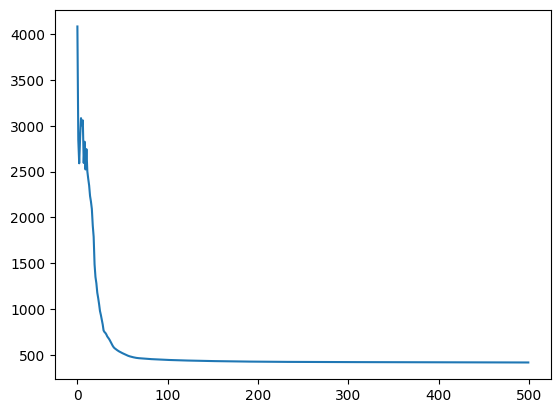

In [49]:
size = 50
around = 5
groups = size // around
matrix = jax.random.uniform(jax.random.PRNGKey(0), (size, 2)) * 2 - 1
edges = (np.arange(size) // around) * around
opt(matrix, partial(force_directed, edges=edges), steps=500)

Make a graph of little rings


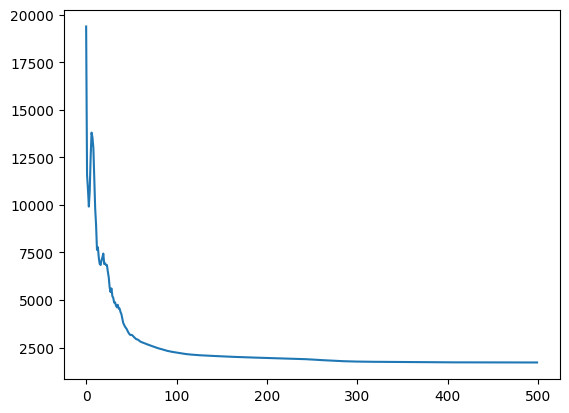

In [50]:
size = 100
matrix = jax.random.uniform(jax.random.PRNGKey(0), (size, 2)) * 2 - 1
edges = (np.arange(size) + 1) % 10 + (np.arange(size) // 10) * 10
opt(matrix, partial(force_directed, edges=edges), steps=500)

## Section 3: Tracing

Now we are going to put everything together by combining
optimization and graphics. The key idea is that if we use
Jax to layout paths, we can optimize based on the result of that layout.
To do this, we need a differentiable way to check where different
paths ended up.

We represent this information through the *trace* function for each path.
A trace function takes in a point and a direction (a *ray*) and returns
a set of lengths at which that ray hits the path. That is sufficient
information to tell us the specific points of intersection.

This is more clear in an animation.

In [68]:
def ray(t, shape, pt, v):
    ray = seg(v).stroke().scale(t + 0.1).translate_by(pt) + circle_at(pt, 0.1)
    trace = shape.get_trace()
    # Length to hit shape.
    s, m = trace(pt, v)
    return shape + ray + circle_at(np.max(s) * v + pt, 0.1).fill_color("red")


shape = circle_at(P2(0, 0), 1).fill_color("white")
animate(partial(ray, shape=shape, pt=P2(0.2, -0.1), v=V2(2, 1)))

Recall from above that arcs are just angles on a
unit circle transformed by $A$. This implies that the trace can be calculated by applying the
inverse of this transform $A^{-1}$ to the ray, and calcuting its distance
to the unit circle.

The formula for this calculation is to find a common point on the ray and the unit circle.
Let's do some algebra. Let $r$ be the length of the trace.

$$ \begin{align*}
x = v_x r + p_x & y = v_y r + p_y \\
x^2 + y^2 &= 1 \\
\Rightarrow& (v_x^2 + v_y^2) r^2 + 2(v_x p_x + v_y p_y) r  + (p_x^2 + p_y^2 - 1) = 0 \\
\Rightarrow& \| v \| r^2 + 2 p \cdot v r  + (\| p \| - 1) = 0 \\
\end{align*}
$$

We then apply the quadratic formula to solve for roots.

\begin{align*}
\frac{-b \pm \sqrt{b^2 - 4a c}}{2a}
\end{align*}

The two values correspond to the two possible intersections.
Negative values correspond to missing the circle.
Once we find the value, we can also compute the angle
of the intersection $r (p + v)$ and check if it is within the
arc.

We can use this with any point, shape, and vector.

In [71]:
shape = arc_seg(V2(2, 0), 0.5).stroke().translate(-1, 0)
animate(partial(ray, shape=shape, pt=P2(0.2, 0.3), v=V2(1, -1)))

Note that there may be multiple intersections between the
ray and the shape. This means trace needs to return a set of values.
Working with sets is difficult in languages like Jax because
array size needs to remain constant in repeated calls to a function.
To handle this issue we return a fixed size array with a mask.

Here's an example that shows multiple intersections,
as well as use of complex affine transformations.

In [72]:
def crescent():
    part1 = arc_seg(unit_x, 0.5)
    part2 = arc_seg(-unit_x, -0.2)
    return part1, part2, (part1 + part2).close().stroke()


def trace(d, t, px=0, py=0):
    # Place the ray
    d = d.center_xy()
    affine = tx.rotation(t * 2 * np.pi)
    pt, v = P2(0, 1.5), V2(0, -1.5)
    pt, v = affine @ pt + V2(px, py), affine @ v

    # Trace gives distance to arcs
    trace = d.get_trace()
    p, m = trace(pt, v)

    # Draw
    line = seg(V2(0, -1 / 2)).stroke()
    out = (
        d
        + line.apply_transform(tx.translation(pt) @ affine)
        + circle_at(pt, 0.1).fill_color("white")
    )
    out = out.line_width(2)
    for i in range(p.shape[1]):
        out = out + circle_at(p[:, i] * v + pt, 0.1).fill_color("red").fill_opacity(
            m[:, i]
        ).line_width(m[:, i])
    return out


animate(partial(trace, crescent()[2]), lw=False)

Internally, we are storing all the arcs that make up a
path. each of these is reset to the unit circle where
we then apply a ray-circle formula to find possible
intersections.

Arc 1

In [74]:
animate(partial(trace, crescent()[0].stroke()), lw=False)

Arc 2.


In [75]:
animate(partial(trace, crescent()[1].stroke(), py=-0.2), lw=False)

Now here's the cool part. Because all of these traces are computed with
jax using differentiable transformations, we can combine them with
our generic gradient optimizer. Here we set up a function that
given any shape and ray will compute and draw the trace.

In [76]:
def draw_trace(d, pt, v):
    # Trace the image
    trace = d.get_trace()
    p, m = trace(pt, v)

    # Draw the raw and trace.
    line = seg(V2(0, -1 / 2)).stroke()
    out = d + seg(v).stroke().translate_by(pt) + circle_at(pt, 0.1).fill_color("white")
    pos = (1 - m[:, :])[..., None, None] * 100 + p[..., None, None] * v + pt
    out = out + Path.from_points([pos[:, 0], pos[:, 1] + eps]).stroke().line_color(
        "white"
    ).line_width(10)
    for i in range(2):
        out = out + circle_at(pos[:, i], 0.1).fill_color("red")
    return out, p

In [77]:
draw_trace(crescent()[2].center_xy(), P2(1, 1), V2(-1, -1))[0]

Using this function, we can then optimize for trace properties.
Here search for the outer angle that leads to the largest trace.
this can just be done with the standard optimizer from the last
section.

In [78]:
def trace_width(d, t):
    d = d.center_xy()
    # Outer satelite
    affine = tx.rotation(t)
    pt, v = affine @ P2(0, 1.5), affine @ V2(0, -1.5)

    # Trace the image
    out, p = draw_trace(d, pt, v)
    score = p[:, 1] - p[:, 0]
    return score.sum(), (grid + out.line_width(1)).layout(500)


opt(np.array(np.pi / 4.0), partial(trace_width, crescent()[2]), rate=0.05)

## Section 4: Vector -> Image

Now that we have a trace function, we are going to use it
to do rasterization, i.e. converting from vector paths to
a visible image, specifical a height $\times$ width $\times$ color array.

Haven't we been doing this all along though? Well kind of.
We have been cheating under the hood and using Cairo
an open-source rasterizer. We want to do it ourself.

To do rasterization, we will use a simple [*scanline*]()
algorithm. The algorithm simply walks down each row one pixel at a time,
runs a trace, and then fills in the middles. To make things
even simpler we will use an *even-odd* rule where we consider
all pixels after an *odd* intersection to be inside the path.


In [83]:
def scanline(t, shape):
    return draw_trace(shape, P2(1, 1 + 10 * t), V2(1, 0))[0]


shape = crescent()[2].scale(7).rotate(70).translate(6, 8).fill_color("orange")
animate(partial(scanline, shape=shape), grid=hgrid, steps=100)

Here's the critical rasterization code.
This function produces 1 row of the image given
the trace for that row. Its job:

* Determine inside pixels.
* Determine boundary pixels
* Be as fast as possible

Here's how you would do this in simple python.

```python
for j in columns:
   even = True
   for mask, split in zip(mask, splits):
       if not mask:
           splits_int[floor(split)] = split
   if j in splits_int:
       split = split_int[j]
       if even:
           scene[j] = 1 - (split - j)
       else:
           scene[j] = split - j
       even = not even
   else:
       if odd:
           scene[j] = 1
```

It's a relatively simple algorithm, but remember we can't use conditionals,
mutation, or dictionaries in Jax. And we want it to run in parallel!


We will instead use an approach of scanline rendering targeting GPUs.
The trick will be to first mark where we cross a boundary and then
use a *cumulative sum* to combine them together. This all can be done in
parallel. Here's the code.


In [85]:
SIZE = 100
blank = np.ones((SIZE, SIZE, 3))

@jax.jit
@jax.vmap
def render_line(splits, mask):
    # Discretize each split to its pixel cell.
    split_int = np.floor(splits).astype(int)

    # `np.where`` will be our if statement replacement.
    # Set `ind` to these values, unless it is masked.
    ind = np.where(mask, split_int, 1000)

    # Create a blank row.
    zero = np.zeros(SIZE)

    # Compute the even / odd position of each split
    # (Assume sorted with masked last)
    loc = np.arange(splits.shape[-1]) % 2

    # Set even->odd pixels as 1 and odd->even as 0.
    inout = np.where(loc, -1, 1)
    scene = zero.at[ind].add(inout)

    # Run a cumulative sum to fill in inside.
    scene = np.cumsum(scene, axis=-1)

    # Set boundaries based on where pixel fell inside.
    scene = scene.at[ind].set(np.where(loc, 0, 1) - inout * (splits - split_int))

    # If we didn't end on even, something went wrong.
    return np.where(mask.sum() % 2 == 0, scene, zero)


shape = crescent()[2].scale(70).rotate(70).translate(60, 80).fill_color("orange")
plt.imshow(render_line(*shape.get_trace()(P2(0, np.arange(100)), V2(1, 0))))
None

Nice! 10 lines of code and we have a rasterizer. It works
pretty nice off the bat. The main problem though is that
it doesn't yet look as good as Cairo's version. The
textbook issue is that we have *aliasing*. If you zoom
into the edge of our moon you will see jagged little edges.

To make things simple, we'll apply anti-aliasing on each
row independently. This is a 1D simplification but it makes
the math much easier.

$$I(x) = \int k(u) f(x- u; \theta) du$$

Where $f(x-u)$ is the value of the line our vector image, $k(x)$ is our kernel, and $I(x)$ is our
output image. The *kernel* is just a function that weights the contribution
to the pixel based on how far away $u$ is.

We can approximate this integral with Monte-Carlo sampling.

$$ I(x) \approx \frac{1}{N} \sum_i k(u_i) f(x - u_i)  $$

Where $u_i$ are $N$ chosen points around $x$.

We'll use a triangle kernel where the weight decays linearly
from the center. To avoid randomness, we'll always separate
the points in a 1D Line. You can think of this a just applying
a 1D convolution to each row of the image.


In [92]:
kern = 11
samples = np.arange(kern) - (kern // 2)


def kernel(offset):
    off_samples = samples - offset
    kernel = kern - np.abs(off_samples)
    return np.maximum(0, kernel / (kern - np.abs(samples)).sum())


plt.plot(samples, kernel(0), "o-")
plt.plot(samples - 0.2, kernel(0.2), "o-")

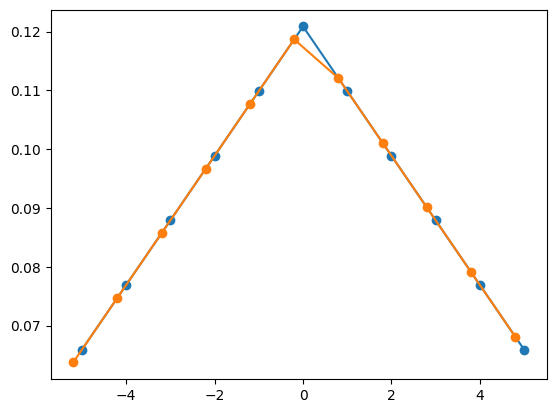

In [93]:
@jax.vmap
def convolve(line):
    k = kernel(0)
    return jax.vmap(lambda s: line[s + samples] @ k)(np.arange(line.shape[0]))


plt.imshow(convolve(render_line(*shape.get_trace()(P2(0, np.arange(100)), V2(1, 0)))))

Now let's put everything together. There are three steps.

1. Scan the image.
2. Anti-Alias with a 1D convolution.
3. Compose the image.

We will do it twice once for rows and once for columns.

In [96]:
directions = list(map(np.stack, [(V2(0, 1), V2(1, 0)), (V2(1, 0), V2(0, 1))]))

In [97]:
@jax.jit
def render_shape(img, s):
    S = np.arange(SIZE)
    trace = s.get_trace()

    def render(img, d):
        pt, v = d
        # 1. Scan
        raster = render_line(*trace(tx.to_point(pt * S[:, None, None]), v))
        # 2. Apply a 1d conv
        raster = convolve(raster)
        # 3. compose
        img = (1 - raster[..., None]) * img + raster[..., None] * s.style.fill_color_
        return np.swapaxes(img, 0, 1), raster

    return jax.lax.scan(render, img, directions)


plt.imshow(render_shape(blank, shape)[0])

We apply the same process for all the paths.


In [99]:
@jax.vmap
def make_shape(i):
    r, g = to_color("red"), to_color("green")
    return shape.translate(-30 + i * 40, -10 + i * 30).fill_color(r * i + g * (1 - i))

def render_shapes(shapes):
    return jax.lax.scan(render_shape, blank, shapes)[0]

plt.imshow(render_shapes(make_shape(np.arange(5) / 5)))

And then just a check that we can render for all transforms.


In [102]:
@jax.jit
def im(t):
    s = shape.center_xy().rotate_by(t).translate(50, 50)
    return render_shape(blank, s)[0]


os.system("rm /tmp/test*.png 2> /dev/null")
for t in range(T):
    plt.imshow(im(t / T))
    plt.savefig(f"/tmp/test.{t:02d}.png")
    plt.clf()

animate_out(sorted(glob.glob("/tmp/test.*.png")))

Now we can do our end-to-end optimization.
We need to specify a goal target image, and then render our
own guess. Here we start with a blue image and target an orange one.
We then optimize through the process to find the color.

In [105]:
goal = render_shape(blank, shape)[0]

def make_shape(color):
    return shape.fill_color(color)

def loss(x):
    y = render_shape(blank, x)[0]
    return np.pow(y - goal, 2).sum(), ((hgrid + x) | (hgrid + shape)).layout(500)

opt(to_color("blue"), lambda x: loss(make_shape(x)), rate=0.1)

## Section 5: Differentiable Rasterization

Changing the color is neat, but unfortunately if the images didn't
line up exactly nothing really would have happened. The problem
is that a key step in our rasterization has a derivative of zero.
Take a look at the `render_line` code and see if you can spot it.

In [109]:
goal = render_shape(blank, shape.translate(5, 5))[0]


def make_shape(color):
    return shape.fill_color(color)


def loss(x):
    y = render_shape(blank, x)[0]
    return np.pow(y - goal, 2).sum(), ((hgrid + x) | (hgrid + shape)).layout(500)


opt(to_color("blue"), lambda x: loss(make_shape(x)), rate=0.1)

The problem is that we are never sending a derivative back through
the `split` variable to the traces, i.e. $\frac{d {\cal L}}{d \ \text{trace}}=0$
That is because the only way split is used is as a discrete index into the
array.

There isn't an trivial way to fix this through scan. The trick instead
is to take advantage of the anti-aliasing step. Recall the formula
for applying the kernel.

$$I(x) = \int k(u) f(x- u) du$$

We would like to take the derivative of this function with
respect to the trace.

$$\frac{d}{d \ \text{trace}} \int k(u) f(x- u) du$$

But where is the trace in this function? We can think about it
as partitioning the integral into *inside* and *outside* parts.
We call each of these regions $A_i$.

$$\sum_i \frac{d}{d \ \text{trace}} \int_{A_i} f(x-u) k(u) du$$

The trace does impact $k$ only the boundary of the
integral. To optimize positioning we need a signal from this boundary position.
The methodology for differentiating through integral boundaries is
a standard identity called Leibniz's integral rule.

$$\frac{d}{db} \int_{0}^{b} z(t) dt = z(b) + \int_{0}^{b} \frac{d z(x)}{d b} dx$$

The second part is the integral with a path. We have taken care of the
already just naturally through our convolution above. The first part
though we need to handle ourselves. For our simplified problem this takes a nice
form.

$$f(x-\text{split}) k(\text{split}) \approx (f(x-\text{split} + \eps) - f(x-\text{split} - \eps))k(\text{split})$$

Where the approximation is necessary because by definition $f(x - \text{split})$ falls on a boundary point.
Intuitively the math is just telling us to move boundaries closer/farther to
targets proportional to their kernel value.

Here's how to implement this in Jax.


In [113]:
@jax.custom_vjp
def boundary(scene, splits, mask):
    "Do nothing on the forward pass."
    return scene


def f_fwd(scene, splits, mask):
    "Blank forward pass."
    return scene, (scene, splits, mask)


def f_bwd(res, g):
    "Backwards pass applies Leibniz."
    f, splits, mask = res
    split_int = np.floor(splits).astype(int)

    def grad_p(s, s_off):
        "Compute the kernel values of neights around this point"
        off = s_off - s
        # Chain rule part.
        v = g[s + samples]
        return (v * (f[s + 1] - f[s - 1])).sum(-1) @ kernel(off)

    # For each split.
    r = jax.vmap(grad_p, in_axes=(-1, -1))(split_int, splits) * mask
    return g, -r, None

In [127]:
boundary.defvjp(f_fwd, f_bwd)

We then can apply it on top of our rendering function.
The idea is that this should not change the image in
any way, but it allows us to correct the derivative.

In [128]:
@jax.jit
def boundary_shape(img, s):
    S = np.arange(SIZE)
    trace = s.get_trace()

    def bound(img, d):
        pt, v = d
        s, m = jax.vmap(lambda i: trace(tx.to_point(pt * i), v))(S)
        bound = lambda s, m: jax.vmap(lambda s, m, im: boundary(im, s, m))(s, m, img)
        img = bound(s, m)
        return np.swapaxes(img, 0, 1), None

    return jax.lax.scan(bound, img, directions)[0], None


def boundaries(img, shapes):
    return jax.lax.scan(boundary_shape, img, shapes)[0]


@jax.vmap
def make_shape1(p):
    loc, color = p
    return (
        shape.center_xy().rotate_by(1 / 4).translate(loc[0], loc[1]).fill_color(color)
    )


# Target vector / raster images
goal_shapes = make_shape1(
    (np.array([[50, 40], [40, 50]]), np.stack([to_color("blue"), to_color("orange")]))
)

img = render_shapes(goal_shapes)
img = boundaries(img, goal_shapes)
plt.imshow(img)
None

So now we can try it out.



In [ ]:
# Target vector / raster images
goal_shapes = make_shape1(
    (np.array([[50, 40], [40, 50]]), np.stack([to_color("blue"), to_color("orange")]))
)
goal = render_shapes(goal_shapes)

In [ ]:
# Initial parameters $x$
start_param = (
    np.array([[60, 30], [60.0, 60.0]]),
    np.stack([to_color("green"), to_color("green")]),
)

In [ ]:
# L2 Loss and draw
def loss(goal, goal_shapes, x):
    y = render_shapes(x)
    y = boundaries(y, x)
    return np.pow(y - goal, 2).sum(), (
        bgrid
        + concat(x).with_envelope(empty())
        + concat(goal_shapes).with_envelope(empty()).fill_opacity(0.2)
    ).layout(500)

In [ ]:
opt(
    start_param,
    lambda x: loss(goal, goal_shapes, make_shape1(x)),
    steps=500,
    save_every=5,
    rate=0.1,
)

Here's a more complex example where we draw a blob shape and let it fill in.
In Jax you can vmap over any sort of tree structure.


In [138]:
@jax.vmap
def make_shape2(params):
    s, l, r = params
    s = np.where(np.abs(s) < 1e-3, 1e-3, s)
    part1 = arc_seg(unit_x, s[0])
    part2 = arc_seg(unit_y, s[1])
    part3 = arc_seg(-unit_x, s[2])
    part4 = arc_seg(-unit_y, s[3])
    d = (part1 + part2 + part3 + part4).close().stroke()
    shape = d.scale(12 + r[0]).rotate(70)
    return shape.center_xy().rotate_by(0).translate(50, 30).fill_color("blue")


goal_params = (
    np.array([[0.5, 0.2, 0.7, -0.9]]),
    np.array([[50.0, 30]]),
    np.array([[5.0]]),
)
goal_shapes = make_shape2(goal_params)
goal = render_shapes(goal_shapes)
start_param = (np.array([[-0.5, 0.1, 2, 1]]), np.array([[50.0, 30]]), np.array([[0.0]]))

opt(
    start_param,
    lambda x: loss(goal, goal_shapes, make_shape2(x)),
    steps=1000,
    save_every=5,
    rate=0.01,
)

In this example we create a bunch or red and blue
circles and then try to fill them in.

In [141]:
import random


@jax.vmap
def make_shape3(params, i):
    s, l = params
    s = np.minimum(np.maximum(s, 5.0), 15)
    red, blue = to_color("red"), to_color("blue")
    return (
        circle_at(tx.X.origin, s)
        .translate(l[0], l[1])
        .fill_color(np.where(i % 2, red, blue))
    )



make_shape3 = partial(make_shape3, i=np.arange(10.0))

goal_param = (
    np.array([10 + random.random() for i in range(10)]),
    np.array([20 + random.random() * 40 for i in range(20)]).reshape(10, 2),
)
goal_shapes = make_shape3(goal_param)

make_shape3 = partial(make_shape3, i=np.arange(20.0))

goal = render_shapes(goal_shapes)
start_param = (
    np.array([10 + random.random() for i in range(20)]),
    np.array([20 + 50 * random.random() for i in range(40)], np.float64).reshape(20, 2),
)


opt(
    start_param,
    lambda x: loss(goal, goal_shapes, make_shape3(x)),
    steps=1000,
    save_every=5,
    rate=0.1,
)

Finally we can test out shapes the multiple in and out
parts likes a star.

In [ ]:
@jax.vmap
def star(x):
    sides = 5
    edge = Trail.hrule(1)
    return (
        Trail.concat(edge.rotate_by((i) / sides) for i in range(sides))
        .close()
        .stroke()
        .center_xy()
        .scale(15)
        .rotate_by(x[1])
        .translate(25 + x[2], 25 + x[3])
        .fill_color("orange")
    )

start_param = np.array(
    [
        [15.0, random.random(), 5 + i * 20, 10 + 20 * j]
        for i in range(3)
        for j in range(3)
    ]
)
g = np.array(
    [
        [15.0, random.random(), 1 + i * 20, 1 + 20 * j]
        for i in range(3)
        for j in range(3)
    ]
)
goal_shapes = star(g)
goal = render_shapes(star(g))

opt(
    start_param,
    lambda x: loss(goal, goal_shapes, star(x)),
    steps=500,
    save_every=2,
    rate=0.05,
    verbose=False,
)

All this work brings us to our final goal, rendering an
actual image. Here we take an image from the web and convert
it to an array. Then we start with a bunch of ellipses (scale-transformed circles)
and see how well they can do to approximate it.
Results are pretty neat!


Grab an image from the web and covert to RGB.

In [150]:
png = Image.open("smiley3.webp").convert("RGBA")
background = Image.new("RGBA", png.size, (255, 255, 255))
pic = Image.alpha_composite(background, png)
pic = pic.convert("RGB")
pic = pic.resize((100, 100))
pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3) / 255
# Set background to white for simplicity.
pix = np.where((pix > 0.8).all(-1)[..., None], 1, pix)
pix = np.where((pix < 0.2).all(-1)[..., None], 0, pix)


In [151]:
goal = pix

# Draw a bunch of circles.
# Parameterize by scale, translation, and roation.
@jax.vmap
def make_smiley(p):
    s, l, r, c, rot = p
    s = np.where(np.abs(s) < 1e-3, (np.abs(s) / s) * 1e-3, s)
    d = circle_at(P2(0, 0), 1).center_xy()
    r = np.where(np.abs(r) < 1e-3, 0.1, (np.abs(r) / r) * r)
    return (
        d.rotate(rot)
        .scale(1)
        .scale_x((r[0]))
        .scale_y((r[1]))
        .translate(l[0], l[1])
        .fill_color(jax.nn.sigmoid(c))
    )


random.seed(1)

# Draw 20 circles with random starting
# values.
n = 20
start_param = (
    np.zeros((n, 4)) + 0.1,
    np.array(
        [[20 + 60 * random.random(), 20 + 60 * random.random()] for i in range(n)]
    ),
    np.ones((n, 2)) + 2 * np.arange(n + 1, 1, -1)[:, None],
    np.ones((n, 3)),
    np.zeros((n, 1)),
)


# Reduce color precision of the goal slightly.
def reduce(y):
    return np.floor(y * 40) / 40


def loss(goal, x):
    y = render_shapes(x)
    y = boundaries(y, x)
    return np.pow(y - reduce(goal), 2).sum(), None


@jax.jit
def show(x):
    return (bgrid + concat(make_smiley(x)).with_envelope(empty()).line_width(0)).layout(
        500
    )


# Optimize!
opt(
    start_param,
    lambda x: loss(goal, make_smiley(x)),
    show=show,
    steps=1000,
    save_every=10,
    rate=0.1,
)

In [ ]:
# ## Conclusion
#
# Graphics is a particularly nice area for this kind of nonsense. 
# Since everything has a nice and well-defined mathematical form,
# with enough work we can push through the necessary gradients.
# We only really had to use one major trick to make derivative 
# work, other wise it was just converting `if`s and `for`s to 
# `np.where` and `vmap`.
#
# Still I think this sort of method is still really underexplored 
# in other areas. We have really nice tools for writing very complex
# programs in a fully vectorized way. I hope I can convince you that 
# while a little scary, this kind of programming is pretty powerful
# and realistically accessible for a lot of different domains. 

# - Sasha